In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt

# import de data set
df_01 = pd.read_csv('data/train.csv', delimiter = ',', encoding = 'latin-1', low_memory = False)
df_01.shape

(250306, 34)

In [2]:
# import de external data files and merge them to the data set
addresses = pd.read_csv('data/addresses.csv', delimiter = ',', encoding = 'latin-1') # 311.307 records
latlons = pd.read_csv('data/latlons.csv', delimiter = ',', encoding = 'latin-1') # 121.769 records

# merge addresses to training dataset, 250.306 records -> every record has a known address
df_02 = pd.merge(df_01, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')

# merge latitudes and longitudes to training dataset, 250.306 records -> every record has a latitude and
# longitude but possibly the wrong ones due to a misspelled address
df_03 = pd.merge(df_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')

# remove records where compliance equals 'Null', 159.880 records
df_04 = df_03.dropna(subset = ['compliance'])

df_02.shape, df_03.shape, df_04.shape

((250306, 35), (250306, 37), (159880, 37))

In [3]:
# make all codes with less than 10 occurrences null in order not to end up with to many dummies later

df_05 = df_04.copy()

features_to_reduce = ['violation_description', 'agency_name', 'disposition', 'state']
    
for feature in features_to_reduce:
    number_categories_before = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = df_05[feature].value_counts()
    df_05.loc[df_05[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    
    print('The number of categories of', feature, 'is reduced from', number_categories_before, 'to', number_categories_after)

The number of categories of violation_description is reduced from 207 to 98
The number of categories of agency_name is reduced from 5 to 5
The number of categories of disposition is reduced from 4 to 4
The number of categories of state is reduced from 60 to 50


In [4]:
# create a new feature: the gap in days between the date the ticket has been issued and the hearing date

def time_gap(input1, input2):
    if not input1 or type(input1) != str: return np.nan
    date1 = datetime.strptime(input1, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(input2, "%Y-%m-%d %H:%M:%S")
    difference = date1 - date2
    return difference.days
    
df_05['time_gap'] = df_05.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis = 1).astype(np.float64)

In [5]:
# a gap up to 100 days seems realistic, however negative gaps (the ticket has been issued after the hearing data) and
# very large gaps of over 365 (one year) seem incorrect. These 'outliers' or errors in the data will be replace by the average

# first we will check how many records contain such gaps
df_05[(df_05['time_gap'] < 0) | (df_05['time_gap'] > 365)]['time_gap'].count()

453

In [6]:
# let's replace these values and the missings already in the dataframe by the average timegap of the non-missings
df_05.loc[(df_05['time_gap'] < 0) | (df_05['time_gap'] > 365), 'time_gap'] = np.nan

mean_time_gap = df_05['time_gap'].mean()
df_05['time_gap'].fillna(mean_time_gap, inplace = True)

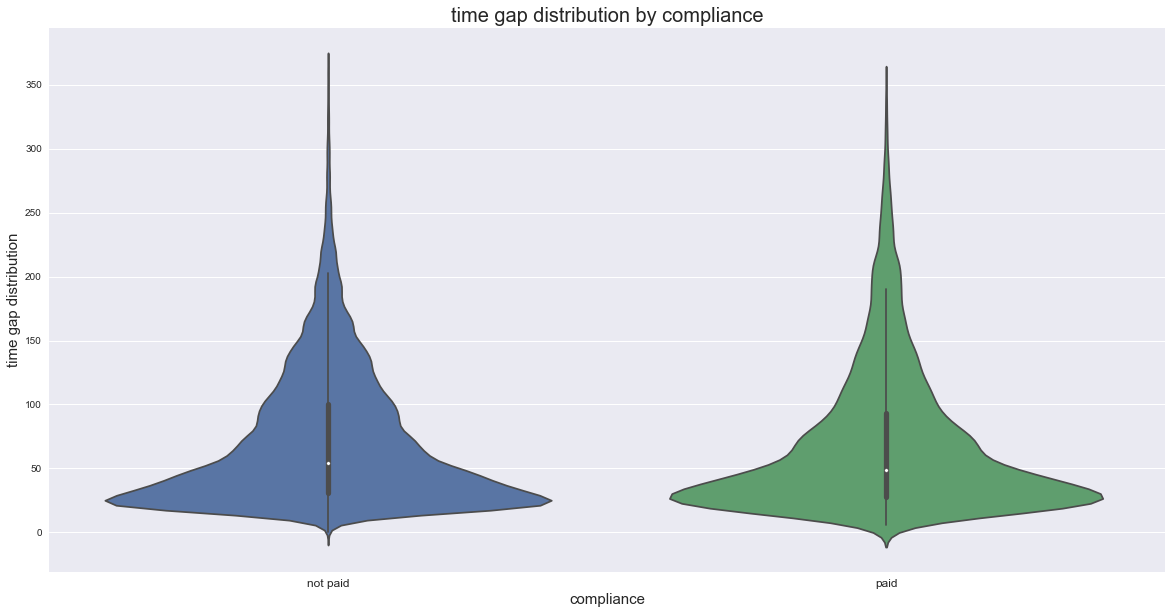

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize = (20, 10))

p = sns.violinplot(data = df_05, x = 'compliance', y = 'time_gap')
p.set_title('time gap distribution by compliance', fontsize = 20)
p.set_xlabel('compliance', fontsize = 15)
p.set_ylabel('time gap distribution', fontsize = 15) 
p.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [8]:
# impute missing values in lat with the average, lon with the average and state with a 'new state' (as in 'other')
mean_lat = df_05['lat'].mean()
mean_lon = df_05['lon'].mean()

df_05['lat'].fillna(mean_lat, inplace = True)
df_05['lon'].fillna(mean_lon, inplace = True)
df_05['state'].fillna('ZZ', inplace = True)

In [9]:
# create the distance of every address to the city of Detroit    
def haversine(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth in kilometers (use 3956 for miles)
    return c * r

# longitude and latitude of Detroit are -83.045753 and 42.331429
df_05['distance'] = df_05.apply(lambda row: haversine(lon1 = -83.045753,
                                                      lat1 = 42.331429,
                                                      lon2 = row['lon'],
                                                      lat2 = row['lat']), axis = 1)

In [10]:
df_05['distance'].groupby(df_05['compliance']).describe()

,count,mean,std,min,25%,50%,75%,max
compliance,,,,,,,,
0.0,148283.0,11.364780,4.296246,0.036816,8.432334,11.47135,13.964312,275.624714
1.0,11597.0,11.095243,4.536442,0.084815,7.711914,11.42643,13.943130,38.978889


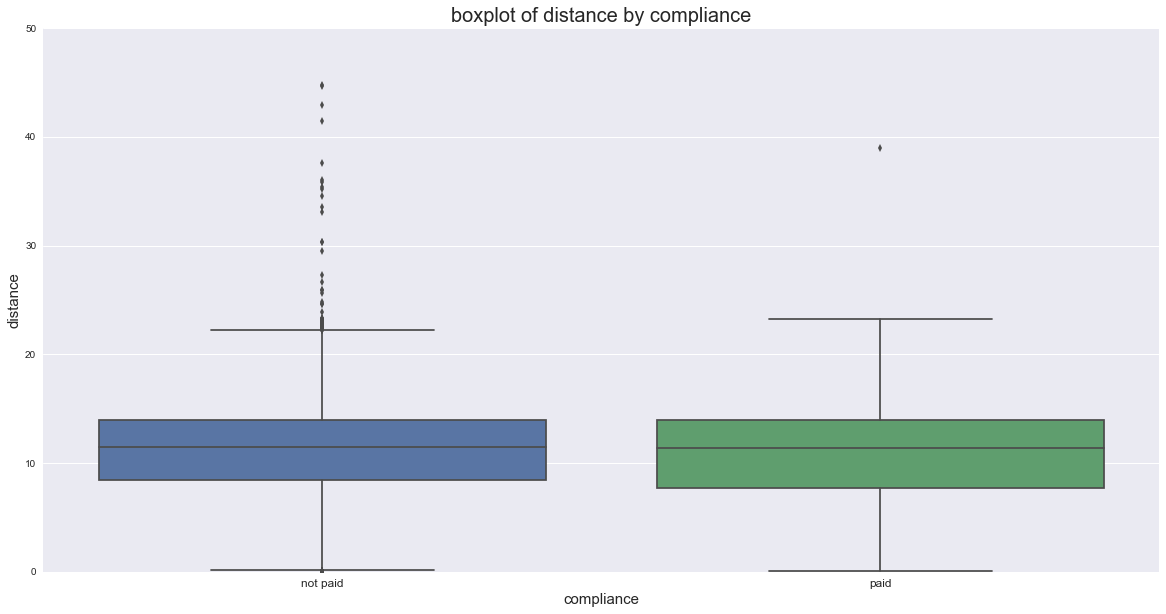

In [11]:
plt.figure(figsize = (20, 10))

bp = sns.boxplot(x = 'compliance', y = 'distance', data = df_05)
bp.set(ylim = (0, 50))
bp.set_title('boxplot of distance by compliance', fontsize = 20)
bp.set_xlabel('compliance', fontsize = 15)
bp.set_ylabel('distance', fontsize = 15) 
bp.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [12]:
# create some additional features
df_05.loc[:, 'distance2']          = df_05.loc[:, 'distance'] * df_05.loc[:, 'distance']
df_05.loc[:, 'distance_admin_fee'] = df_05.loc[:, 'distance'] * df_05.loc[:, 'admin_fee']
df_05.loc[:, 'distance_state_fee'] = df_05.loc[:, 'distance'] * df_05.loc[:, 'state_fee']
df_05.loc[:, 'distance_late_fee']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'late_fee']
df_05.loc[:, 'distance_discount']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'discount_amount']
df_05.loc[:, 'distance_judgment']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'judgment_amount']
df_05.loc[:, 'distance_time_gap']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'time_gap']

In [13]:
df_05.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,lon,time_gap,distance,distance2,distance_admin_fee,distance_state_fee,distance_late_fee,distance_discount,distance_judgment,distance_time_gap
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,-83.124268,71.66581,9.224702,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,661.095759
1,77242,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INV. INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,34.00000,9.224702,85.095131,184.494044,92.247022,461.235111,0.0,5350.327287,313.639875
2,77243,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MORTGAGE CO., MIDWEST",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,34.00000,9.224702,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,313.639875
4,138219,Department of Public Works,"Talbert, Reginald","INVESTMENT INC, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S WACKER #1418,CHICAGO,...,-83.124268,136.00000,9.224702,85.095131,184.494044,92.247022,92.247022,0.0,1291.458311,1254.559502
5,177558,"Buildings, Safety Engineering & Env Department","Morris, John","INVESTMENT, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,81.00000,9.224702,85.095131,184.494044,92.247022,276.741067,0.0,3320.892799,747.200880


In [14]:
# selecting the features
feature_names = ['ticket_id', 'violation_description', 'agency_name', 'disposition', 'discount_amount',
                 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'state', 'lat', 'lon', 'distance', 'time_gap',
                 'distance2', 'distance_admin_fee', 'distance_state_fee', 'distance_late_fee', 'distance_discount',
                 'distance_judgment', 'distance_time_gap']

x = df_05[feature_names]
x = x.set_index('ticket_id')

y = df_05['compliance']

# recoding the categorical features to numerical ones
x['violation_description'] = x['violation_description'].astype('category')
violation_description_dict = dict(enumerate(x.violation_description.cat.categories))
violation_description_dict2 = {y:x for x,y in violation_description_dict.items()}
x['violation_description'] = x['violation_description'].cat.codes
mode_violation_description = x['violation_description'].mode()[0]

x['agency_name'] = x['agency_name'].astype('category')
agency_name_dict = dict(enumerate(x.agency_name.cat.categories))
agency_name_dict2 = {y:x for x,y in agency_name_dict.items()}
x['agency_name'] = x['agency_name'].cat.codes
mode_agency_name = x['agency_name'].mode()[0]

x['disposition'] = x['disposition'].astype('category')
disposition_dict = dict(enumerate(x.disposition.cat.categories))
disposition_dict2 = {y:x for x,y in disposition_dict.items()}
x['disposition'] = x['disposition'].cat.codes
mode_disposition = x['disposition'].mode()[0]

x['state'] = x['state'].astype('category')
state_dict = dict(enumerate(x.state.cat.categories))
state_dict2 = {y:x for x,y in state_dict.items()}
x['state'] = x['state'].cat.codes

In [15]:
x.head()

,violation_description,agency_name,disposition,discount_amount,admin_fee,state_fee,late_fee,judgment_amount,state,lat,lon,distance,time_gap,distance2,distance_admin_fee,distance_state_fee,distance_late_fee,distance_discount,distance_judgment,distance_time_gap
ticket_id,,,,,,,,,,,,,,,,,,,,
22056,33,0,2,0.0,20.0,10.0,25.0,305.0,14,42.390729,-83.124268,9.224702,71.66581,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,661.095759
77242,33,0,2,0.0,20.0,10.0,50.0,580.0,14,42.390729,-83.124268,9.224702,34.00000,85.095131,184.494044,92.247022,461.235111,0.0,5350.327287,313.639875
77243,52,0,2,0.0,20.0,10.0,25.0,305.0,14,42.390729,-83.124268,9.224702,34.00000,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,313.639875
138219,81,1,2,0.0,20.0,10.0,10.0,140.0,14,42.390729,-83.124268,9.224702,136.00000,85.095131,184.494044,92.247022,92.247022,0.0,1291.458311,1254.559502
177558,29,0,2,0.0,20.0,10.0,30.0,360.0,14,42.390729,-83.124268,9.224702,81.00000,85.095131,184.494044,92.247022,276.741067,0.0,3320.892799,747.200880


In [16]:
# some of the features are numerical but have no order so it's better to convert them to dummies
feature_to_be_splitted = ['violation_description', 'agency_name', 'disposition', 'state']
    
x = pd.get_dummies(x, columns = feature_to_be_splitted)

In [17]:
corr = x.corr().abs()
s = corr.unstack().to_frame().reset_index()
s.columns = ['Feature1', 'Feature2', 'Correlation']
s[(s['Correlation'] > 0.9) & (s['Correlation'] <= 0.99)].sort_values('Correlation', ascending = False)

,Feature1,Feature2,Correlation
2090,distance_late_fee,distance_judgment,0.989240
2434,distance_judgment,distance_late_fee,0.989240
523,late_fee,judgment_amount,0.989070
695,judgment_amount,late_fee,0.989070
531,late_fee,distance_late_fee,0.940410
2079,distance_late_fee,late_fee,0.940410
13,discount_amount,distance_discount,0.938221
2249,distance_discount,discount_amount,0.938221
706,judgment_amount,distance_judgment,0.936776
2426,distance_judgment,judgment_amount,0.936776


In [18]:
# remove some features that cause multicollinearity
#   - distance_judgment
#   - late_fee
#   - discount_amount

multicollinearity = ['distance_judgment', 'late_fee', 'discount_amount']

features_no_multi = [feature for feature in x.columns if feature not in multicollinearity]
x_no_multi = x[features_no_multi]

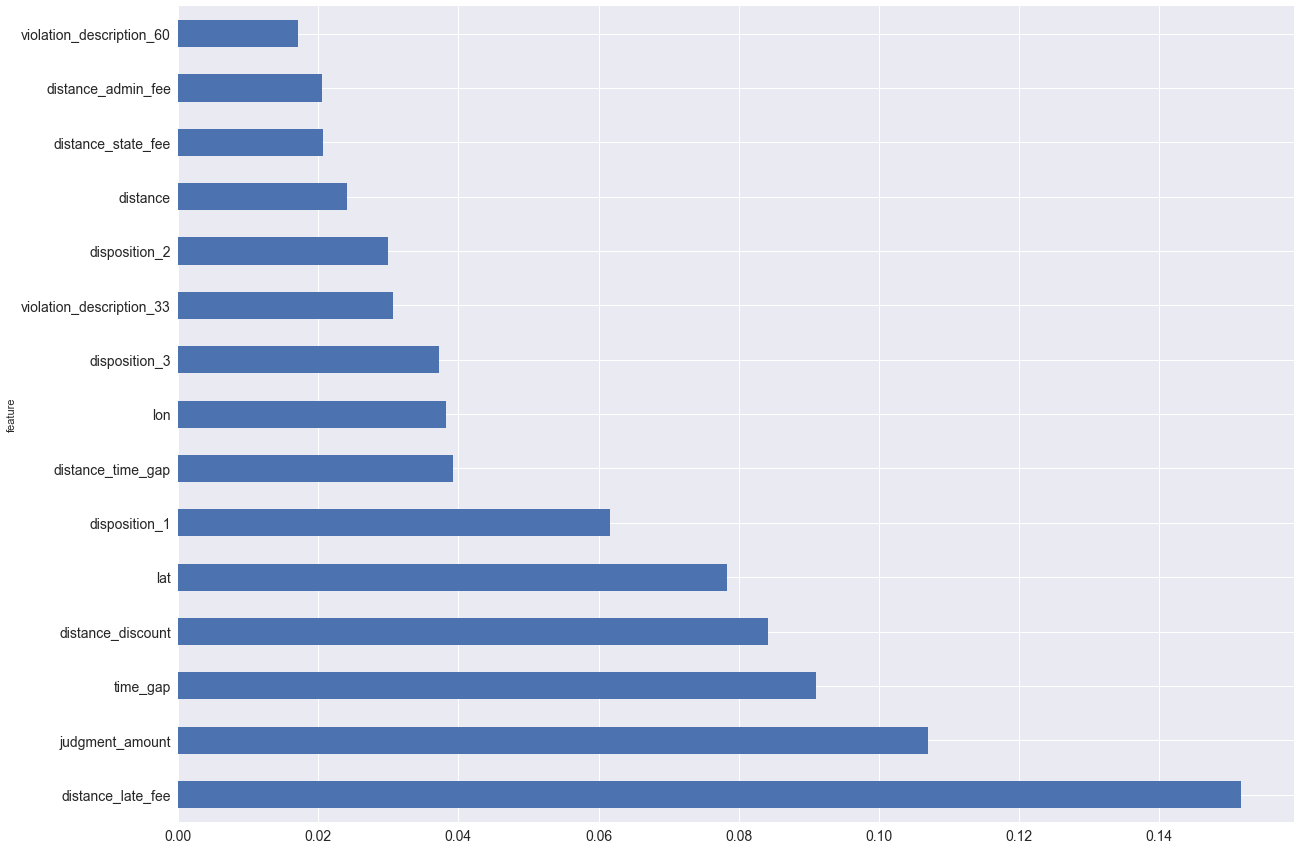

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt

clf = GradientBoostingClassifier(random_state = 0).fit(x_no_multi, y)

features = []

for feature, importance in zip(x_no_multi.columns, clf.feature_importances_):
    features.append((importance, feature))

features.sort(reverse = True)
features_relevant = [x_no_multi[1] for x_no_multi in features if x_no_multi[0] > 0]

features = pd.DataFrame()

features['feature'] = x_no_multi.columns
features['importance'] = clf.feature_importances_

features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

# plot the 'top 15' features
features[:-16:-1].plot(kind = 'barh', figsize = (20, 15), legend = None)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()

In [20]:
# import de test data
test_df_01 = pd.read_csv('data/test.csv', delimiter = ',', encoding = 'latin-1', low_memory = False)

In [21]:
# apply the same transformations as done on the training data
test_df_02 = pd.merge(test_df_01, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')
test_df_03 = pd.merge(test_df_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')
    
for feature in features_to_reduce:
    number_categories_before = test_df_03[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = test_df_03[feature].value_counts()
    test_df_03.loc[test_df_03[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = test_df_03[feature].value_counts(dropna = False).to_frame().shape[0]

test_df_03['time_gap'] = test_df_03.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis = 1).astype(np.float64)
test_df_03['time_gap'] = np.where((test_df_03['time_gap'] < 0) | (test_df_03['time_gap'] > 365), np.nan, test_df_03['time_gap'])
test_df_03['time_gap'].fillna(mean_time_gap, inplace = True)

test_df_03['lat'].fillna(mean_lat, inplace = True)
test_df_03['lon'].fillna(mean_lon, inplace = True)
test_df_03['state'].fillna('ZZ', inplace = True)

test_df_03['distance'] = test_df_03.apply(lambda row: haversine(lon1 = -83.045753, lat1 = 42.331429, lon2 = row['lon'], lat2 = row['lat']), axis = 1)

test_df_03['distance2'] = test_df_03['distance'] * test_df_03['distance']
test_df_03['distance_admin_fee'] = test_df_03['distance'] * test_df_03['admin_fee']
test_df_03['distance_state_fee'] = test_df_03['distance'] * test_df_03['state_fee']
test_df_03['distance_late_fee'] = test_df_03['distance'] * test_df_03['late_fee']
test_df_03['distance_discount'] = test_df_03['distance'] * test_df_03['discount_amount']
test_df_03['distance_judgment'] = test_df_03['distance'] * test_df_03['judgment_amount']
test_df_03['distance_time_gap'] = test_df_03['distance'] * test_df_03['time_gap']

test_df_03['violation_description'] = test_df_03['violation_description'].map(violation_description_dict2)
test_df_03['violation_description'].fillna(mode_violation_description, inplace = True)
test_df_03['violation_description'] = test_df_03['violation_description'].astype(np.int8)

test_df_03['agency_name'] = test_df_03['agency_name'].map(agency_name_dict2)
test_df_03['agency_name'].fillna(mode_agency_name, inplace = True)
test_df_03['agency_name'] = test_df_03['agency_name'].astype(np.int8)

test_df_03['disposition'] = test_df_03['disposition'].map(disposition_dict2)
test_df_03['disposition'].fillna(mode_disposition, inplace = True)
test_df_03['disposition'] = test_df_03['disposition'].astype(np.int8)

test_df_03['state'] = test_df_03['state'].map(state_dict2)
test_df_03['state'].fillna(49, inplace = True)
test_df_03['state'] = test_df_03['state'].astype(np.int8)

test_df_03 = pd.get_dummies(test_df_03, columns = feature_to_be_splitted)

test_df_03 = test_df_03.set_index('ticket_id')

In [22]:
# make sure the algorithm is not being trained on features not available in the test set
train_features = x_no_multi[features_relevant].columns
train_features_set = set(train_features)
    
for feature in set(train_features):
    if feature not in test_df_03:
        train_features_set.remove(feature)
train_features = list(train_features_set)
    
x_input = x[train_features]
test_df_03 = test_df_03[train_features]

In [23]:
x_input.shape, test_df_03.shape

((159880, 53), (61001, 53))

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

x_train, x_val, y_train, y_val = train_test_split(x_input, y, random_state = 0)

clf = GradientBoostingClassifier(learning_rate = 0.03, max_depth = 5, random_state = 0).fit(x_train, y_train)

# area under the curve (AUC) score for training dataset
y_train_score = clf.predict_proba(x_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_score)
    
# area under the curve (AUC) score for test dataset
y_val_score = clf.predict_proba(x_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_score)

print('ROC for training set: ', "{0:.3f}".format(roc_auc_train))
print('ROC for the validation set: ', "{0:.3f}".format(roc_auc_val))

ROC for training set:  0.824
ROC for the validation set:  0.814


In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

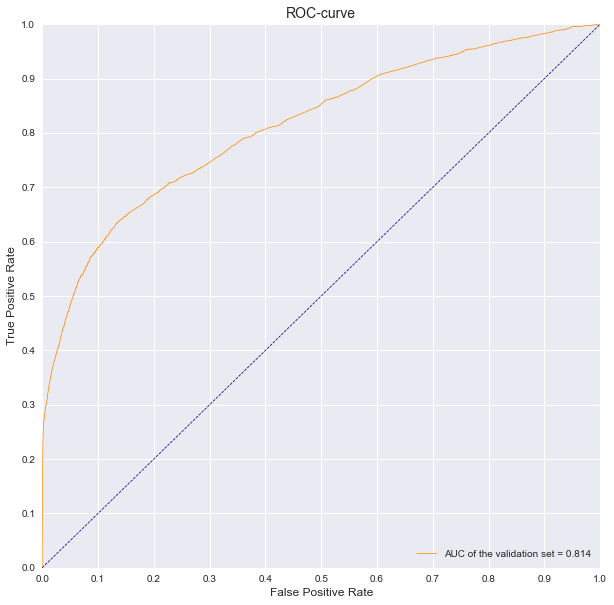

In [26]:
# plot the ROC-curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_val, y_val_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 10))

ax = plt.gca()

plt.title('ROC-curve', fontsize = 14)
plt.plot(fpr, tpr, color = 'darkorange', lw = 0.75, label = 'AUC of the validation set = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 0.75, linestyle = '--')

xticks_major = np.round(np.linspace(0, 1, 11), 1)
xticks_major_str = (xticks_major).astype(str).tolist()
xticks_labels = [x for x in xticks_major_str]

yticks_major = np.round(np.linspace(0, 1, 11), 1)
yticks_major_str = (yticks_major).astype(str).tolist()
yticks_labels = [x for x in yticks_major_str]

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(xticks_major)
ax.set_xticklabels(xticks_labels, fontsize = 10)
ax.set_yticks(yticks_major)
ax.set_yticklabels(yticks_labels, fontsize = 10)

plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.show()

In [27]:
# the final predictions for the test set
prediction_proba = clf.predict_proba(test_df_03)[:,1]
test_df_03['compliance'] = prediction_proba.astype(np.float32)
test_df_03.compliance.head()

ticket_id
284932    0.068401
285362    0.021421
285361    0.047902
285338    0.065524
285346    0.075429
Name: compliance, dtype: float32